<a href="https://colab.research.google.com/github/chocogenius/workshop2020/blob/main/MIMIC_Race_Classification_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup and Data Import

In [ ]:
### Package imports

from google.colab import auth
import pandas as pd

from collections import Counter
from google.colab import widgets
import numpy as np
import pandas as pd
import pickle
from sklearn import metrics, model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt 

In [ ]:
### Authentication for MIMIC

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
### Import notes from MIMIC
%%bigquery --project adept-box-313502 data
SELECT *
FROM `physionet-data.mimiciii_notes.noteevents` a
JOIN `physionet-data.mimiciii_clinical.admissions` b ON a.HADM_ID = b.HADM_ID
WHERE CATEGORY IN ('Nursing','Nursing/other')

In [ ]:
### Import notes from MIMIC
%%bigquery --project adept-box-313502 patients
SELECT *
FROM `physionet-data.mimiciii_clinical.patients`

In [ ]:
patients.columns = patients.columns.str.lower()

In [ ]:
### Save data for easier reference
data.to_csv('/content/drive/MyDrive/MIMIC_Race/data.csv')

### Data Cleaning

In [ ]:
### Load saved data
data = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/data.csv')
data.columns = data.columns.str.lower()

In [ ]:
### Filter to only include black and white patients
data_class = data.loc[(data.ethnicity == 'WHITE') | (data.ethnicity == 'BLACK/AFRICAN AMERICAN')].copy()
data_class["y"] = 1*(data_class.ethnicity == 'BLACK/AFRICAN AMERICAN')

In [ ]:
### Aggregate notes by patient, and only keep first visit for patients who had multiple ICU visits
data_patient = data_class.groupby(['subject_id','hadm_id', 'admittime'], as_index = False).agg({'text': '\nNEW NOTE\n'.join, 'y': sum}).sort_values(['subject_id','admittime'])
data_patient['visit_no'] = data_patient.groupby(['subject_id'], as_index = False).cumcount()+1
data_patient['y'] = 1*(data_patient['y']>0)
data_patient = data_patient.loc[data_patient.visit_no < 2]

In [ ]:
### Split into notes and outcomes
notes = data_patient.text
y =  data_patient.y

In [ ]:
### Strip out obvious indicators of race
notes_clean = notes.str.replace('african-american', '', case = False)
notes_clean = notes_clean.str.replace('african american', '', case = False)
notes_clean = notes_clean.str.replace('african', '', case = False)
notes_clean = notes_clean.str.replace('black', '', case = False)

notes_clean = notes_clean.str.replace('caucasian', '', case = False)
notes_clean = notes_clean.str.replace('white', '', case = False)

In [ ]:
### Train test split
notes_train, notes_test, y_train, y_test, data_patient_train, data_patient_test = train_test_split(notes_clean, y, data_patient, test_size=0.3, random_state=0)

In [ ]:
### Sanity check dimensionality
print(notes_train.shape)
print(y_train.shape)
print(data_patient_train.shape)
print(notes_test.shape)
print(y_test.shape)
print(data_patient_test.shape)

(19663,)
(19663,)
(19663, 6)
(8427,)
(8427,)
(8427, 6)


In [ ]:
### Save train and test data for easier reference
notes_train.to_csv('/content/drive/MyDrive/MIMIC_Race/notes_train.csv', index=False)
notes_test.to_csv('/content/drive/MyDrive/MIMIC_Race/notes_test.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/MIMIC_Race/y_train.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/MIMIC_Race/y_test.csv', index=False)
data_patient_train.to_csv('/content/drive/MyDrive/MIMIC_Race/data_patient_train.csv', index=False)
data_patient_test.to_csv('/content/drive/MyDrive/MIMIC_Race/data_patient_test.csv', index=False)

In [ ]:
### Load saved train and test data
notes_train = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/notes_train.csv')
notes_test = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/notes_test.csv')
y_train = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/y_test.csv')
data_patient_train = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/data_patient_train.csv')
data_patient_test = pd.read_csv('/content/drive/MyDrive/MIMIC_Race/data_patient_test.csv')

notes_train = notes_train.text 
notes_test = notes_test.text 
y_train = y_train.y
y_test = y_test.y

In [ ]:
### Sanity check dimensionality

print(notes_train.shape)
print(y_train.shape)
print(data_patient_train.shape)
print(notes_test.shape)
print(y_test.shape)
print(data_patient_test.shape)

(19663,)
(19663,)
(19663, 6)
(8427,)
(8427,)
(8427, 6)


In [ ]:
notes_train

0        NARRATIVE NOTE:\n\nCV: B/P HAS RANGED FROM 100...
1        1900-0700 NPN\n\n\n#2F/E/N\nO:TF AT 140CC/KG. ...
2        pmicu npn 7p-7a\n\n\n   36yo woman presented t...
3        Remains on HiFlow O2 at 95% via face tent.  Sa...
4        T/SICU NSG Admission Note\n(Continued)\n in ef...
                               ...                        
19658    NURSING NOTE 7A-7P Review of Systems:\nNEURO: ...
19659    SICU NURSING PROGRESS NOTE 0700-1900\nPRIEST I...
19660    Observed above procedure and reveiwed note, ag...
19661    75 yr male, suffered cardiac arrest while play...
19662    Attending Triage Note\nBG [**Known lastname 50...
Name: text, Length: 19663, dtype: object

### Simplest Model (Unigram, BOW, Logit)

In [ ]:
### Turn raw notes into BOW matrix
unigram_bow = CountVectorizer(ngram_range=(1,1))
X_train = unigram_bow.fit_transform(notes_train)
X_test = unigram_bow.transform(notes_test)

In [ ]:
%%time
### Train with cross validation
logit_unigram = LogisticRegressionCV(Cs = [0.001, 0.01, 0.1], random_state=0, cv=5, scoring='roc_auc',\
                                     penalty = 'l1', solver='liblinear', class_weight='balanced', max_iter=150)
logit_unigram.fit(X_train, y_train)

print(logit_unigram.C_)

[0.01]
CPU times: user 6min 40s, sys: 880 ms, total: 6min 41s
Wall time: 6min 40s


In [ ]:
### Print results
print('Train Set Results')

print('Accuracy:', logit_unigram.score(X_train, y_train))
print('AUC:', roc_auc_score(y_train, logit_unigram.predict_proba(X_train)[:, 1]))

print('Test Set Results')

print('Accuracy', logit_unigram.score(X_test, y_test))
print('AUC', roc_auc_score(y_test, logit_unigram.predict_proba(X_test)[:, 1]))

print('Test Set Details')
print(classification_report(y_test, logit_unigram.predict(X_test), target_names=["White", "Black"]))

Train Set Results
Accuracy: 0.8766331882064011
AUC: 0.8766331882064011
Test Set Results
Accuracy 0.7923680050208266
AUC 0.7923680050208266
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.74      0.84      7586
       Black       0.24      0.72      0.35       841

    accuracy                           0.74      8427
   macro avg       0.60      0.73      0.60      8427
weighted avg       0.89      0.74      0.79      8427



In [ ]:
### Words most predictive of black patients
vocab = unigram_bow.get_feature_names()
top = 20
indices = list(np.argsort(logit_unigram.coef_[0])[-top:][::-1])
list(zip([vocab[i] for i in indices], [logit_unigram.coef_[0][i] for i in indices]))

[('mongolian', 0.963372300404336),
 ('members', 0.16058955396828717),
 ('sickle', 0.15521833907319987),
 ('stick', 0.09574736670615566),
 ('asthma', 0.08032733773524942),
 ('gbs', 0.0763023991803041),
 ('hiv', 0.07538239990009939),
 ('htn', 0.07492032113577196),
 ('palliative', 0.07487571497680683),
 ('difficult', 0.07353697517373278),
 ('quiet', 0.06957432346711019),
 ('d5w', 0.06623174396782298),
 ('obtain', 0.06402625001248825),
 ('anuric', 0.0636207786816823),
 ('2192', 0.06311634978293783),
 ('another', 0.062300046632465016),
 ('obese', 0.06134770955511634),
 ('eating', 0.06036185819169246),
 ('ble', 0.05846585978656264),
 ('170', 0.05650471116332802)]

In [ ]:
### Words most predictive of white patients
bottom = 20
indices = list(np.argsort(logit_unigram.coef_[0])[:bottom])
list(zip([vocab[i] for i in indices], [logit_unigram.coef_[0][i] for i in indices]))

[('reddened', -0.3936130125894193),
 ('ecchymotic', -0.27306685077056053),
 ('russian', -0.15601629191696337),
 ('bruising', -0.13562554794007764),
 ('grunting', -0.12995753365618914),
 ('ruddy', -0.1286138933420933),
 ('pale', -0.1078363478616601),
 ('rash', -0.10780387339135394),
 ('husband', -0.08903381284683436),
 ('red', -0.08562124876865618),
 ('94', -0.0841116427465392),
 ('carotid', -0.07555797156999966),
 ('ecchymosis', -0.07542667193837962),
 ('osh', -0.07523103363073906),
 ('cabg', -0.0703095468240652),
 ('breastfeeding', -0.06594813647758246),
 ('anxiety', -0.06486635141033259),
 ('cmo', -0.06402451728403903),
 ('purple', -0.06333530745326282),
 ('cooling', -0.062381378942042015)]

In [ ]:
### Print sample note
print(notes_train[(notes_train.str.lower().str.find('pallative care') !=-1)].iloc[2])

NPN 1900-0700
S: Intubated

O: Please see careview for all objective data.

Neuro: Sedation weaned to Fentanyl 50mcg/hr and Versed 2mg/hr, responds with slight movement to suctioning and turning side to side. Bilateral wrist restraints for safety precautions, not withdrawing to any stimulus. PERRL 2mm/sluggish. Head CT (-) for ICH/mass.

Resp: Vented AC 600x22/.[**5-17**] to maintain adequate oxygenation. Worsening metabolic acidosis. Sxn several times for tan/yellowish thick secretions. CXR showed L lobe PNA, CT w/ LLL collapse d/t pleural effusion. Lung sounds are coarse/rhonchorus throughout, bronchial LLL.

CV: NSR, freq atrial bigeminy with rare to occ PVC's. Cont levophed, titrated to MAP >60-65. Heparin gtt @1800u/hr, PTT pending 0600.   Left arm elevated d/t dependent swelling, extremities cool/pale. Pulses are dopplerable.

GI: Restarted TFs, minimal residuals. Obese, gross ascites, abd distended and soft; +BS, stool OB(-)., Mushroom cath in place with decreased output. ABD CT

### Bigram, BOW, Logit

In [ ]:
bigram_bow = CountVectorizer(ngram_range=(1,2), min_df=2)
X_train = bigram_bow.fit_transform(notes_train)
X_test = bigram_bow.transform(notes_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(22472, 2059371)
(5618, 2059371)


In [ ]:
%%time
logit_bigram = LogisticRegression(C = 0.01, random_state=0, penalty = 'l1', solver='liblinear', class_weight='balanced')
logit_bigram.fit(X_train, y_train)

CPU times: user 3min 52s, sys: 886 ms, total: 3min 53s
Wall time: 3min 52s


In [ ]:
%%time
logit_bigram = LogisticRegressionCV(Cs=[1e-3, 1e-2, 1e-1], cv = 5, random_state=0, penalty = 'l1', solver='liblinear', class_weight='balanced', scoring='roc_auc')
logit_bigram.fit(X_train, y_train)
print(logit_unigram.C_)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.01]
CPU times: user 1h 3s, sys: 6.17 s, total: 1h 9s
Wall time: 59min 53s


In [ ]:
print('Train Set Results')

print('Accuracy:', logit_bigram.score(X_train, y_train))
print('AUC:', roc_auc_score(y_train, logit_bigram.predict_proba(X_train)[:, 1]))

print('Test Set Results')

print('Accuracy', logit_bigram.score(X_test, y_test))
print('AUC', roc_auc_score(y_test, logit_bigram.predict_proba(X_test)[:, 1]))

print('Test Set Details')
print(classification_report(y_test, logit_bigram.predict(X_test), target_names=["White", "Black"]))

Train Set Results
Accuracy: 0.8849976821906698
AUC: 0.8849976821906698
Test Set Results
Accuracy 0.7930570520261838
AUC 0.7930570520261838
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.75      0.84      7586
       Black       0.24      0.72      0.37       841

    accuracy                           0.75      8427
   macro avg       0.60      0.74      0.60      8427
weighted avg       0.89      0.75      0.80      8427



In [ ]:
vocab = bigram_bow.get_feature_names()
top = 20
indices = list(np.argsort(logit_bigram.coef_[0])[-top:][::-1])
list(zip([vocab[i] for i in indices], [logit_bigram.coef_[0][i] for i in indices]))

[('mongolian', 0.9757105248527002),
 ('members', 0.1636162620300493),
 ('sickle', 0.14572467710187215),
 ('sats 100', 0.13839436699369964),
 ('stick', 0.10412845503008843),
 ('palliative', 0.07744381635849246),
 ('rr 40', 0.07742352917547343),
 ('difficult', 0.07730709907286837),
 ('100 on', 0.07588242945686545),
 ('asthma', 0.07441730688102564),
 ('who presented', 0.07396445479225254),
 ('htn', 0.07295812885658162),
 ('laryngeal edema', 0.07195736693656397),
 ('d5w', 0.06906371922145885),
 ('hiv', 0.06803902405267813),
 ('gbs', 0.06706043289107498),
 ('2802', 0.06534791876713966),
 ('in nsr', 0.06493788536907018),
 ('2192', 0.06341657408772806),
 ('anuric', 0.06188117812635669)]

In [ ]:
bottom = 20
indices = list(np.argsort(logit_bigram.coef_[0])[:bottom])
list(zip([vocab[i] for i in indices], [logit_bigram.coef_[0][i] for i in indices]))

[('reddened', -0.3939676043163387),
 ('ecchymotic', -0.25634850813050114),
 ('russian', -0.13884409501932662),
 ('bruising', -0.1285555201573902),
 ('grunting', -0.12486617051990863),
 ('rash', -0.11721787746970097),
 ('ruddy', -0.11272860099256825),
 ('pale', -0.10644516272344626),
 ('red', -0.08494219740254322),
 ('94', -0.08409444718242808),
 ('husband', -0.08262691371201107),
 ('ecchymosis', -0.08008127809351466),
 ('osh', -0.07459091520684576),
 ('cabg', -0.0731087532498388),
 ('cooling', -0.07240172527161853),
 ('sbp 140', -0.07115971578856219),
 ('carotid', -0.07012025733915646),
 ('cmo', -0.06709362692275611),
 ('anxious', -0.06543380790521605),
 ('anxiety', -0.0630954004603131)]

In [ ]:
print(notes_train[(notes_train.str.lower().str.find('') !=-1)].iloc[0])

### Unigram TF-IDF

In [ ]:
unigram_bow = CountVectorizer(ngram_range=(1,1))
X_train = unigram_bow.fit_transform(notes_train)
X_test = unigram_bow.transform(notes_test)

unigram_tf = TfidfTransformer()
X_train = unigram_tf.fit_transform(X_train)
X_test = unigram_tf.transform(X_test)

In [ ]:
%%time
logit_unigram_tf = LogisticRegressionCV(Cs = [1e-3, 1e-2, 1e-1], random_state=0, cv=5, penalty = 'l1', solver='liblinear', class_weight='balanced', scoring = 'roc_auc')
logit_unigram_tf.fit(X_train, y_train)
print(logit_unigram_tf.C_)

[0.001]
CPU times: user 27.5 s, sys: 274 ms, total: 27.8 s
Wall time: 27.7 s


In [ ]:
%%time
logit_unigram_tf = LogisticRegression(C = 1e-1, random_state=0, penalty = 'l1', solver='liblinear', class_weight='balanced')
logit_unigram_tf.fit(X_train, y_train)

CPU times: user 3 s, sys: 14.9 ms, total: 3.02 s
Wall time: 3.01 s


In [ ]:
print('Train Set Results')

print('Accuracy:', logit_unigram_tf.score(X_train, y_train))
print('AUC:', roc_auc_score(y_train, logit_unigram_tf.predict_proba(X_train)[:, 1]))

print('Test Set Results')

print('Accuracy', logit_unigram_tf.score(X_test, y_test))
print('AUC', roc_auc_score(y_test, logit_unigram_tf.predict_proba(X_test)[:, 1]))

print('Test Set Details')
print(classification_report(y_test, logit_unigram_tf.predict(X_test), target_names=["White", "Black"]))

Train Set Results
Accuracy: 0.6734603061587754
AUC: 0.7277909334385397
Test Set Results
Accuracy 0.6712353150587398
AUC 0.7148582689605282
Test Set Details
              precision    recall  f1-score   support

       White       0.94      0.68      0.79      5046
       Black       0.18      0.63      0.28       572

    accuracy                           0.67      5618
   macro avg       0.56      0.65      0.53      5618
weighted avg       0.86      0.67      0.74      5618



In [ ]:
vocab = unigram_tf.get_feature_names()
top = 20
indices = list(np.argsort(logit_unigram_tf.coef_[0])[-top:][::-1])
list(zip([vocab[i] for i in indices], [logit_unigram_tf.coef_[0][i] for i in indices]))

[('zzzzofran', 0.0),
 ('coninuous', 0.0),
 ('conisitent', 0.0),
 ('conisistently', 0.0),
 ('conisistent', 0.0),
 ('conisderation', 0.0),
 ('conisder', 0.0),
 ('coninutes', 0.0),
 ('coninuted', 0.0),
 ('coninute', 0.0),
 ('coninus', 0.0),
 ('coninuously', 0.0),
 ('coninuing', 0.0),
 ('congestion', 0.0),
 ('coninues', 0.0),
 ('coninued', 0.0),
 ('coninue', 0.0),
 ('coninuation', 0.0),
 ('coninually', 0.0),
 ('conintune', 0.0)]

In [ ]:
bottom = 20
indices = list(np.argsort(logit_unigram_tf.coef_[0])[:bottom])
list(zip([vocab[i] for i in indices], [logit_unigram_tf.coef_[0][i] for i in indices]))

[('00', 0.0),
 ('nursinfg', 0.0),
 ('nursing', 0.0),
 ('nursingassessment', 0.0),
 ('nursingf', 0.0),
 ('nursingg', 0.0),
 ('nursinghome', 0.0),
 ('nursingi', 0.0),
 ('nursingnote', 0.0),
 ('nursingp', 0.0),
 ('nursingprogress', 0.0),
 ('nursings', 0.0),
 ('nursingt', 0.0),
 ('nursinh', 0.0),
 ('nursinmg', 0.0),
 ('nursinsg', 0.0),
 ('nursint', 0.0),
 ('nursintg', 0.0),
 ('nursiong', 0.0),
 ('nursisng', 0.0)]

### Final Model

In [ ]:
### Feature generation for bag-of-words
unigram_bow = CountVectorizer(ngram_range=(1,1))
X_train = unigram_bow.fit_transform(notes_train)
X_test = unigram_bow.transform(notes_test)

In [ ]:
%%time
### Train model
logit = LogisticRegression(C=0.01, random_state=0, penalty = 'l1', solver='liblinear', class_weight='balanced')
logit.fit(X_train, y_train)

CPU times: user 23.1 s, sys: 27.8 ms, total: 23.1 s
Wall time: 23.1 s


In [ ]:
### Print results

print('Train Set Results')

print('Accuracy:', metrics.accuracy_score(y_train, logit.predict(X_train)))
print('AUC:', roc_auc_score(y_train, logit.predict_proba(X_train)[:, 1]))

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_test, logit.predict(X_test)))
print('AUC', roc_auc_score(y_test, logit.predict_proba(X_test)[:, 1]))

print('Test Set Details')
print(classification_report(y_test, logit.predict(X_test), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_test, logit.predict(X_test)))

Train Set Results
Accuracy: 0.7651426537150994
AUC: 0.8766331882064011
Test Set Results
Accuracy 0.7395277085558325
AUC 0.7923680050208266
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.74      0.84      7586
       Black       0.24      0.72      0.35       841

    accuracy                           0.74      8427
   macro avg       0.60      0.73      0.60      8427
weighted avg       0.89      0.74      0.79      8427

[[5628 1958]
 [ 237  604]]


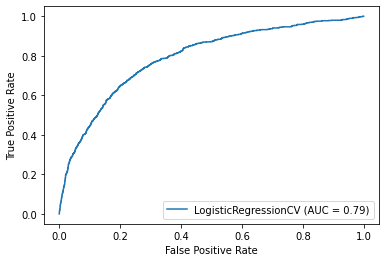

In [ ]:
metrics.plot_roc_curve(logit, X_test, y_test)  
plt.show()     

In [ ]:
### Most predictive of black patient
vocab = unigram_bow.get_feature_names()
top = 20
indices = list(np.argsort(logit.coef_[0])[-top:][::-1])
list(zip([vocab[i] for i in indices], [logit.coef_[0][i] for i in indices]))

[('mongolian', 0.963372300404336),
 ('members', 0.16058955396828717),
 ('sickle', 0.15521833907319987),
 ('stick', 0.09574736670615566),
 ('asthma', 0.08032733773524942),
 ('gbs', 0.0763023991803041),
 ('hiv', 0.07538239990009939),
 ('htn', 0.07492032113577196),
 ('palliative', 0.07487571497680683),
 ('difficult', 0.07353697517373278),
 ('quiet', 0.06957432346711019),
 ('d5w', 0.06623174396782298),
 ('obtain', 0.06402625001248825),
 ('anuric', 0.0636207786816823),
 ('2192', 0.06311634978293783),
 ('another', 0.062300046632465016),
 ('obese', 0.06134770955511634),
 ('eating', 0.06036185819169246),
 ('ble', 0.05846585978656264),
 ('170', 0.05650471116332802)]

In [ ]:
### Most predictive of white patient
bottom = 20
indices = list(np.argsort(logit.coef_[0])[:bottom])
list(zip([vocab[i] for i in indices], [logit.coef_[0][i] for i in indices]))

[('reddened', -0.3936130125894193),
 ('ecchymotic', -0.27306685077056053),
 ('russian', -0.15601629191696337),
 ('bruising', -0.13562554794007764),
 ('grunting', -0.12995753365618914),
 ('ruddy', -0.1286138933420933),
 ('pale', -0.1078363478616601),
 ('rash', -0.10780387339135394),
 ('husband', -0.08903381284683436),
 ('red', -0.08562124876865618),
 ('94', -0.0841116427465392),
 ('carotid', -0.07555797156999966),
 ('ecchymosis', -0.07542667193837962),
 ('osh', -0.07523103363073906),
 ('cabg', -0.0703095468240652),
 ('breastfeeding', -0.06594813647758246),
 ('anxiety', -0.06486635141033259),
 ('cmo', -0.06402451728403903),
 ('purple', -0.06333530745326282),
 ('cooling', -0.062381378942042015)]

### Get Patient Comorbidities

In [ ]:
### Get comorbidities from MIMIC
%%bigquery --project adept-box-313502 comorbities
with eliflg as
(
select hadm_id, seq_num, icd9_code
, CASE
  when icd9_code in ('39891','40201','40211','40291','40401','40403','40411','40413','40491','40493') then 1
  when SUBSTR(icd9_code, 1, 4) in ('4254','4255','4257','4258','4259') then 1
  when SUBSTR(icd9_code, 1, 3) in ('428') then 1
  else 0 end as chf       /* Congestive heart failure */

, CASE
  when icd9_code in ('42613','42610','42612','99601','99604') then 1
  when SUBSTR(icd9_code, 1, 4) in ('4260','4267','4269','4270','4271','4272','4273','4274','4276','4278','4279','7850','V450','V533') then 1
  else 0 end as arrhy

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('0932','7463','7464','7465','7466','V422','V433') then 1
  when SUBSTR(icd9_code, 1, 3) in ('394','395','396','397','424') then 1
  else 0 end as valve     /* Valvular disease */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('4150','4151','4170','4178','4179') then 1
  when SUBSTR(icd9_code, 1, 3) in ('416') then 1
  else 0 end as pulmcirc  /* Pulmonary circulation disorder */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('0930','4373','4431','4432','4438','4439','4471','5571','5579','V434') then 1
  when SUBSTR(icd9_code, 1, 3) in ('440','441') then 1
  else 0 end as perivasc  /* Peripheral vascular disorder */

, CASE
  when SUBSTR(icd9_code, 1, 3) in ('401') then 1
  else 0 end as htn       /* Hypertension, uncomplicated */

, CASE
  when SUBSTR(icd9_code, 1, 3) in ('402','403','404','405') then 1
  else 0 end as htncx     /* Hypertension, complicated */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('3341','3440','3441','3442','3443','3444','3445','3446','3449') then 1
  when SUBSTR(icd9_code, 1, 3) in ('342','343') then 1
  else 0 end as para      /* Paralysis */

, CASE
  when icd9_code in ('33392') then 1
  when SUBSTR(icd9_code, 1, 4) in ('3319','3320','3321','3334','3335','3362','3481','3483','7803','7843') then 1
  when SUBSTR(icd9_code, 1, 3) in ('334','335','340','341','345') then 1
  else 0 end as neuro     /* Other neurological */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('4168','4169','5064','5081','5088') then 1
  when SUBSTR(icd9_code, 1, 3) in ('490','491','492','493','494','495','496','500','501','502','503','504','505') then 1
  else 0 end as chrnlung  /* Chronic pulmonary disease */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2500','2501','2502','2503') then 1
  else 0 end as dm        /* Diabetes w/o chronic complications*/

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2504','2505','2506','2507','2508','2509') then 1
  else 0 end as dmcx      /* Diabetes w/ chronic complications */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2409','2461','2468') then 1
  when SUBSTR(icd9_code, 1, 3) in ('243','244') then 1
  else 0 end as hypothy   /* Hypothyroidism */

, CASE
  when icd9_code in ('40301','40311','40391','40402','40403','40412','40413','40492','40493') then 1
  when SUBSTR(icd9_code, 1, 4) in ('5880','V420','V451') then 1
  when SUBSTR(icd9_code, 1, 3) in ('585','586','V56') then 1
  else 0 end as renlfail  /* Renal failure */

, CASE
  when icd9_code in ('07022','07023','07032','07033','07044','07054') then 1
  when SUBSTR(icd9_code, 1, 4) in ('0706','0709','4560','4561','4562','5722','5723','5724','5728','5733','5734','5738','5739','V427') then 1
  when SUBSTR(icd9_code, 1, 3) in ('570','571') then 1
  else 0 end as liver     /* Liver disease */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('5317','5319','5327','5329','5337','5339','5347','5349') then 1
  else 0 end as ulcer     /* Chronic Peptic ulcer disease (includes bleeding only if obstruction is also present) */

, CASE
  when SUBSTR(icd9_code, 1, 3) in ('042','043','044') then 1
  else 0 end as aids      /* HIV and AIDS */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2030','2386') then 1
  when SUBSTR(icd9_code, 1, 3) in ('200','201','202') then 1
  else 0 end as lymph     /* Lymphoma */

, CASE
  when SUBSTR(icd9_code, 1, 3) in ('196','197','198','199') then 1
  else 0 end as mets      /* Metastatic cancer */

, CASE
  when SUBSTR(icd9_code, 1, 3) in
  (
     '140','141','142','143','144','145','146','147','148','149','150','151','152'
    ,'153','154','155','156','157','158','159','160','161','162','163','164','165'
    ,'166','167','168','169','170','171','172','174','175','176','177','178','179'
    ,'180','181','182','183','184','185','186','187','188','189','190','191','192'
    ,'193','194','195'
  ) then 1
  else 0 end as tumor     /* Solid tumor without metastasis */

, CASE
  when icd9_code in ('72889','72930') then 1
  when SUBSTR(icd9_code, 1, 4) in ('7010','7100','7101','7102','7103','7104','7108','7109','7112','7193','7285') then 1
  when SUBSTR(icd9_code, 1, 3) in ('446','714','720','725') then 1
  else 0 end as arth              /* Rheumatoid arthritis/collagen vascular diseases */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2871','2873','2874','2875') then 1
  when SUBSTR(icd9_code, 1, 3) in ('286') then 1
  else 0 end as coag      /* Coagulation deficiency */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2780') then 1
  else 0 end as obese     /* Obesity      */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('7832','7994') then 1
  when SUBSTR(icd9_code, 1, 3) in ('260','261','262','263') then 1
  else 0 end as wghtloss  /* Weight loss */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2536') then 1
  when SUBSTR(icd9_code, 1, 3) in ('276') then 1
  else 0 end as lytes     /* Fluid and electrolyte disorders */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2800') then 1
  else 0 end as bldloss   /* Blood loss anemia */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2801','2808','2809') then 1
  when SUBSTR(icd9_code, 1, 3) in ('281') then 1
  else 0 end as anemdef  /* Deficiency anemias */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2652','2911','2912','2913','2915','2918','2919','3030','3039','3050','3575','4255','5353','5710','5711','5712','5713','V113') then 1
  when SUBSTR(icd9_code, 1, 3) in ('980') then 1
  else 0 end as alcohol /* Alcohol abuse */

, CASE
  when icd9_code in ('V6542') then 1
  when SUBSTR(icd9_code, 1, 4) in ('3052','3053','3054','3055','3056','3057','3058','3059') then 1
  when SUBSTR(icd9_code, 1, 3) in ('292','304') then 1
  else 0 end as drug /* Drug abuse */

, CASE
  when icd9_code in ('29604','29614','29644','29654') then 1
  when SUBSTR(icd9_code, 1, 4) in ('2938') then 1
  when SUBSTR(icd9_code, 1, 3) in ('295','297','298') then 1
  else 0 end as psych /* Psychoses */

, CASE
  when SUBSTR(icd9_code, 1, 4) in ('2962','2963','2965','3004') then 1
  when SUBSTR(icd9_code, 1, 3) in ('309','311') then 1
  else 0 end as depress  /* Depression */
from `physionet-data.mimiciii_clinical.diagnoses_icd` icd
where seq_num != 1 -- we do not include the primary icd-9 code
)
-- collapse the icd9_code specific flags into hadm_id specific flags
-- this groups comorbidities together for a single patient admission
, eligrp as
(
  select hadm_id
  , max(chf) as chf
  , max(arrhy) as arrhy
  , max(valve) as valve
  , max(pulmcirc) as pulmcirc
  , max(perivasc) as perivasc
  , max(htn) as htn
  , max(htncx) as htncx
  , max(para) as para
  , max(neuro) as neuro
  , max(chrnlung) as chrnlung
  , max(dm) as dm
  , max(dmcx) as dmcx
  , max(hypothy) as hypothy
  , max(renlfail) as renlfail
  , max(liver) as liver
  , max(ulcer) as ulcer
  , max(aids) as aids
  , max(lymph) as lymph
  , max(mets) as mets
  , max(tumor) as tumor
  , max(arth) as arth
  , max(coag) as coag
  , max(obese) as obese
  , max(wghtloss) as wghtloss
  , max(lytes) as lytes
  , max(bldloss) as bldloss
  , max(anemdef) as anemdef
  , max(alcohol) as alcohol
  , max(drug) as drug
  , max(psych) as psych
  , max(depress) as depress
from eliflg
group by hadm_id
)
-- now merge these flags together to define elixhauser
-- most are straightforward.. but hypertension flags are a bit more complicated


select adm.hadm_id
, chf as congestive_heart_failure
, arrhy as cardiac_arrhythmias
, valve as valvular_disease
, pulmcirc as pulmonary_circulation
, perivasc as peripheral_vascular
-- we combine "htn" and "htncx" into "HYPERTENSION"
, case
    when htn = 1 then 1
    when htncx = 1 then 1
  else 0 end as hypertension
, para as paralysis
, neuro as other_neurological
, chrnlung as chronic_pulmonary
-- only the more severe comorbidity (complicated diabetes) is kept
, case
    when dmcx = 1 then 0
    when dm = 1 then 1
  else 0 end as diabetes_uncomplicated
, dmcx as diabetes_complicated
, hypothy as hypothyroidism
, renlfail as renal_failure
, liver as liver_disease
, ulcer as peptic_ulcer
, aids as aids
, lymph as lymphoma
, mets as metastatic_cancer
-- only the more severe comorbidity (metastatic cancer) is kept
, case
    when mets = 1 then 0
    when tumor = 1 then 1
  else 0 end as solid_tumor
, arth as rheumatoid_arthritis
, coag as coagulopathy
, obese as obesity
, wghtloss as weight_loss
, lytes as fluid_electrolyte
, bldloss as blood_loss_anemia
, anemdef as deficiency_anemias
, alcohol as alcohol_abuse
, drug as drug_abuse
, psych as psychoses
, depress as depression

FROM `physionet-data.mimiciii_clinical.admissions` adm
left join eligrp eli
  on adm.hadm_id = eli.hadm_id
order by adm.hadm_id;

In [ ]:
### Join with train and test tables
comorb_train = data_patient_train.merge(comorbities, on = ['hadm_id'])
comorb_test  = data_patient_test.merge(comorbities, on = ['hadm_id'])

### Diabetes, Hypertension, CPD, Obesity

In [ ]:
### Final model performance on patients with diabetes
notes_diabetic = notes_test[comorb_test.diabetes_uncomplicated==1]
X_diabetic = unigram_bow.transform(notes_diabetic)
y_diabetic = y_test[comorb_test.diabetes_uncomplicated==1]

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_diabetic, logit.predict(X_diabetic)))
print('AUC', roc_auc_score(y_diabetic, logit.predict_proba(X_diabetic)[:, 1]))

print('Test Set Details')
print(classification_report(y_diabetic, logit.predict(X_diabetic), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_diabetic, logit.predict(X_diabetic)))

Test Set Results
Accuracy 0.7705047318611987
AUC 0.7860876334519573
Test Set Details
              precision    recall  f1-score   support

       White       0.94      0.79      0.86      1124
       Black       0.27      0.62      0.38       144

    accuracy                           0.77      1268
   macro avg       0.61      0.70      0.62      1268
weighted avg       0.87      0.77      0.80      1268

[[888 236]
 [ 55  89]]


In [ ]:
### Final model performance on patients with hypertension
notes_ht = notes_test[comorb_test.hypertension==1]
X_ht = unigram_bow.transform(notes_ht)
y_ht = y_test[comorb_test.hypertension==1]

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_ht, logit.predict(X_ht)))
print('AUC', roc_auc_score(y_ht, logit.predict_proba(X_ht)[:, 1]))

print('Test Set Details')
print(classification_report(y_ht, logit.predict(X_ht), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_ht, logit.predict(X_ht)))

Test Set Results
Accuracy 0.7876030707989764
AUC 0.7934086546611908
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.80      0.87      3171
       Black       0.27      0.66      0.38       346

    accuracy                           0.79      3517
   macro avg       0.61      0.73      0.62      3517
weighted avg       0.89      0.79      0.82      3517

[[2543  628]
 [ 119  227]]


In [ ]:
### Final model performance on patients with COPD
notes_cpd = notes_test[comorb_test.chronic_pulmonary==1]
X_cpd = unigram_bow.transform(notes_cpd)
y_cpd = y_test[comorb_test.chronic_pulmonary==1]

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_cpd, logit.predict(X_cpd)))
print('AUC', roc_auc_score(y_cpd, logit.predict_proba(X_cpd)[:, 1]))

print('Test Set Details')
print(classification_report(y_cpd, logit.predict(X_cpd), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_cpd, logit.predict(X_cpd)))

Test Set Results
Accuracy 0.7897553516819572
AUC 0.7987754655781915
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.80      0.87      1193
       Black       0.25      0.68      0.36       115

    accuracy                           0.79      1308
   macro avg       0.60      0.74      0.62      1308
weighted avg       0.90      0.79      0.83      1308

[[955 238]
 [ 37  78]]


In [ ]:
### Final model performance on obese patients
notes_obese = notes_test[comorb_test.obesity==1]
X_obese = unigram_bow.transform(notes_obese)
y_obese = y_test[comorb_test.obesity==1]

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_obese, logit.predict(X_obese)))
print('AUC', roc_auc_score(y_obese, logit.predict_proba(X_obese)[:, 1]))

print('Test Set Details')
print(classification_report(y_obese, logit.predict(X_obese), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_obese, logit.predict(X_obese)))

Test Set Results
Accuracy 0.7803030303030303
AUC 0.808845029239766
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.78      0.86       228
       Black       0.36      0.81      0.50        36

    accuracy                           0.78       264
   macro avg       0.66      0.79      0.68       264
weighted avg       0.88      0.78      0.81       264

[[177  51]
 [  7  29]]


### Comorbidity Score

In [ ]:
### Compute VW comorbidity score

comorb_test["vw_score"] = 0 * comorb_test.aids + \
   0 * comorb_test.alcohol_abuse + \
  -2 * comorb_test.blood_loss_anemia + \
   7 * comorb_test.congestive_heart_failure + \
   3 * comorb_test.chronic_pulmonary + \
   3 * comorb_test.coagulopathy + \
  -2 * comorb_test.deficiency_anemias + \
  -3 * comorb_test.depression + \
   0 * comorb_test.diabetes_complicated + \
   0 * comorb_test.diabetes_uncomplicated + \
  -7 * comorb_test.drug_abuse + \
   5 * comorb_test.fluid_electrolyte + \
   0 * comorb_test.hypertension + \
   0 * comorb_test.hypothyroidism + \
   11 * comorb_test.liver_disease + \
   9 * comorb_test.lymphoma + \
   12 * comorb_test.metastatic_cancer + \
   6 * comorb_test.other_neurological + \
  -4 * comorb_test.obesity + \
   7 * comorb_test.paralysis + \
   2 * comorb_test.peripheral_vascular + \
   0 * comorb_test.peptic_ulcer + \
   0 * comorb_test.psychoses + \
   4 * comorb_test.pulmonary_circulation + \
   0 * comorb_test.rheumatoid_arthritis + \
   5 * comorb_test.renal_failure + \
   4 * comorb_test.solid_tumor + \
  -1 * comorb_test.valvular_disease + \
   6 * comorb_test.weight_loss
  
comorb_test["score"] = comorb_test.iloc[:,6:(6+30)].sum(axis=1)

In [ ]:
### Compute score deciles
comorb_test['vw_decile'] = pd.qcut(comorb_test['vw_score'], 10, labels=False, duplicates='drop')
comorb_test['score_decile'] = pd.qcut(comorb_test['score'], 10, labels=False, duplicates='drop')

comorb_test['vw_decile'] = comorb_test['vw_decile'] + 10 - max(comorb_test['vw_decile'])
comorb_test['score_decile'] = comorb_test['score_decile'] + 10 - max(comorb_test['score_decile'])

In [ ]:
### Final model performance on bottom decile
coval = min(comorb_test.vw_decile)
notes_lowco = notes_test[comorb_test.vw_decile==coval]
X_lowco = unigram_bow.transform(notes_lowco)
y_lowco = y_test[comorb_test.vw_decile==coval]

y_this = y_lowco
X_this = X_lowco

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.6913089560148383
AUC 0.788944741604435
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.68      0.80      3358
       Black       0.23      0.76      0.35       416

    accuracy                           0.69      3774
   macro avg       0.59      0.72      0.57      3774
weighted avg       0.88      0.69      0.75      3774

[[2292 1066]
 [  99  317]]


In [ ]:
### Final model performance on top decile
coval = max(comorb_test.vw_decile)
notes_hico = notes_test[comorb_test.vw_decile==coval]
X_hico = unigram_bow.transform(notes_hico)
y_hico = y_test[comorb_test.vw_decile==coval]

y_this = y_hico
X_this = X_hico

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.76171875
AUC 0.7882058856948073
Test Set Details
              precision    recall  f1-score   support

       White       0.95      0.77      0.85       677
       Black       0.29      0.70      0.41        91

    accuracy                           0.76       768
   macro avg       0.62      0.74      0.63       768
weighted avg       0.87      0.76      0.80       768

[[521 156]
 [ 27  64]]


### Unit Type

In [ ]:
### Get info from MIMIC on unit type
%%bigquery --project adept-box-313502 icu
SELECT *
FROM `physionet-data.mimiciii_clinical.icustays`

In [ ]:
### Data processing
icu.columns = icu.columns.str.lower()
units = list(set().union(icu.first_careunit.unique(),icu.last_careunit.unique()))
for unit in units:
  icu[unit] = ((icu.first_careunit == unit) | (icu.last_careunit == unit))*1+0
icu = icu.groupby(['hadm_id'], as_index=False).agg({'MICU':max, 'TSICU':max, 'SICU':max, 'CCU':max, 'NICU':max, 'CSRU':max})

unit_test = data_patient_test.merge(icu, 'left')

In [ ]:
### Final model performance on patients in MICU

notes_micu = notes_test[unit_test.MICU==1]
X_micu = unigram_bow.transform(notes_micu)
y_micu = y_test[unit_test.MICU==1]

y_this = y_micu
X_this = X_micu

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.6914197768372451
AUC 0.7810571699804862
Test Set Details
              precision    recall  f1-score   support

       White       0.95      0.68      0.79      2264
       Black       0.26      0.74      0.38       335

    accuracy                           0.69      2599
   macro avg       0.60      0.71      0.59      2599
weighted avg       0.86      0.69      0.74      2599

[[1548  716]
 [  86  249]]


In [ ]:
### Final model performance on patients in CCU

notes_ccu = notes_test[unit_test.CCU==1]
X_ccu = unigram_bow.transform(notes_ccu)
y_ccu = y_test[unit_test.CCU==1]

y_this = y_ccu
X_this = X_ccu

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.827115559599636
AUC 0.7741151545363909
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.85      0.90      1003
       Black       0.27      0.58      0.37        96

    accuracy                           0.83      1099
   macro avg       0.61      0.72      0.64      1099
weighted avg       0.90      0.83      0.85      1099

[[853 150]
 [ 40  56]]


In [ ]:
### Final model performance on patients in NICU

notes_nicu = notes_test[unit_test.NICU==1]
X_nicu = unigram_bow.transform(notes_nicu)
y_nicu = y_test[unit_test.NICU==1]

y_this = y_nicu
X_this = X_nicu

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.5466903073286052
AUC 0.7724841856031994
Test Set Details
              precision    recall  f1-score   support

       White       0.95      0.49      0.65      1439
       Black       0.23      0.85      0.36       253

    accuracy                           0.55      1692
   macro avg       0.59      0.67      0.50      1692
weighted avg       0.84      0.55      0.61      1692

[[710 729]
 [ 38 215]]


In [ ]:
### Compare rates of certain words in NICU patients
print('Mongolian')
print(sum((notes_nicu.str.lower().str.find('mongolian')!=-1) & (y_nicu ==1)) / sum(y_nicu))
print(sum((notes_nicu.str.lower().str.find('mongolian')!=-1) & (y_nicu ==0)) / (len(y_nicu) - sum(y_nicu)))

print('Asthma')
print(sum((notes_nicu.str.lower().str.find('asthma')!=-1) & (y_nicu ==1)) / sum(y_nicu))
print(sum((notes_nicu.str.lower().str.find('asthma')!=-1) & (y_nicu ==0)) / (len(y_nicu) - sum(y_nicu)))

print('HIV')
print(sum((notes_nicu.str.lower().str.find('hiv')!=-1) & (y_nicu ==1)) / sum(y_nicu))
print(sum((notes_nicu.str.lower().str.find('hiv')!=-1) & (y_nicu ==0)) / (len(y_nicu) - sum(y_nicu)))

print('members')
print(sum((notes_nicu.str.lower().str.find('members')!=-1) & (y_nicu ==1)) / sum(y_nicu))
print(sum((notes_nicu.str.lower().str.find('members')!=-1) & (y_nicu ==0)) / (len(y_nicu) - sum(y_nicu)))

print('difficult')
print(sum((notes_nicu.str.lower().str.find('difficult')!=-1) & (y_nicu ==1)) / sum(y_nicu))
print(sum((notes_nicu.str.lower().str.find('difficult')!=-1) & (y_nicu ==0)) / (len(y_nicu) - sum(y_nicu)))

Mongolian
0.2727272727272727
0.006254343293954135
Asthma
0.09090909090909091
0.03683113273106324
HIV
0.04743083003952569
0.019457956914523976
members
0.1383399209486166
0.08756080611535788
difficult
0.308300395256917
0.28908964558721334


In [ ]:
### Compare rates of certain words in MICU patients
print('Mongolian')
print(sum((notes_micu.str.lower().str.find('mongolian')!=-1) & (y_micu ==1)) / sum(y_micu))
print(sum((notes_micu.str.lower().str.find('mongolian')!=-1) & (y_micu ==0)) / (len(y_micu) - sum(y_micu)))

print('Asthma')
print(sum((notes_micu.str.lower().str.find('asthma')!=-1) & (y_micu ==1)) / sum(y_micu))
print(sum((notes_micu.str.lower().str.find('asthma')!=-1) & (y_micu ==0)) / (len(y_micu) - sum(y_micu)))

print('HIV')
print(sum((notes_micu.str.lower().str.find('hiv')!=-1) & (y_micu ==1)) / sum(y_micu))
print(sum((notes_micu.str.lower().str.find('hiv')!=-1) & (y_micu ==0)) / (len(y_micu) - sum(y_micu)))

print('members')
print(sum((notes_micu.str.lower().str.find('members')!=-1) & (y_micu ==1)) / sum(y_micu))
print(sum((notes_micu.str.lower().str.find('members')!=-1) & (y_micu ==0)) / (len(y_micu) - sum(y_micu)))

print('difficult')
print(sum((notes_micu.str.lower().str.find('difficult')!=-1) & (y_micu ==1)) / sum(y_micu))
print(sum((notes_micu.str.lower().str.find('difficult')!=-1) & (y_micu ==0)) / (len(y_micu) - sum(y_micu)))

Mongolian
0.0
0.0
Asthma
0.11044776119402985
0.05653710247349823
HIV
0.08955223880597014
0.054770318021201414
members
0.21492537313432836
0.18860424028268552
difficult
0.5940298507462687
0.5521201413427562


In [ ]:
### Final model performance on patients in SICU

notes_sicu = notes_test[unit_test.SICU==1]
X_sicu = unigram_bow.transform(notes_sicu)
y_sicu = y_test[unit_test.SICU==1]

y_this = y_sicu
X_this = X_sicu

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.7998430141287284
AUC 0.8018581382883687
Test Set Details
              precision    recall  f1-score   support

       White       0.96      0.81      0.88      1158
       Black       0.27      0.70      0.39       116

    accuracy                           0.80      1274
   macro avg       0.62      0.75      0.63      1274
weighted avg       0.90      0.80      0.84      1274

[[938 220]
 [ 35  81]]


In [ ]:
### Final model performance on patients in TSICU

notes_tsicu = notes_test[unit_test.TSICU==1]
X_tsicu = unigram_bow.transform(notes_tsicu)
y_tsicu = y_test[unit_test.TSICU==1]

y_this = y_tsicu
X_this = X_tsicu

print('Test Set Results')

print('Accuracy', metrics.accuracy_score(y_this, logit.predict(X_this)))
print('AUC', roc_auc_score(y_this, logit.predict_proba(X_this)[:, 1]))

print('Test Set Details')
print(classification_report(y_this, logit.predict(X_this), target_names=["White", "Black"]))
print(metrics.confusion_matrix(y_this, logit.predict(X_this)))

Test Set Results
Accuracy 0.8605341246290801
AUC 0.7901474353315088
Test Set Details
              precision    recall  f1-score   support

       White       0.98      0.87      0.92       964
       Black       0.18      0.57      0.28        47

    accuracy                           0.86      1011
   macro avg       0.58      0.72      0.60      1011
weighted avg       0.94      0.86      0.89      1011

[[843 121]
 [ 20  27]]


### Investigate Patterns

In [ ]:
### Feature generation for bag-of-words
bigram_bow = CountVectorizer(ngram_range=(2,2))
X_train_bi = bigram_bow.fit_transform(notes_train)

trigram_bow = CountVectorizer(ngram_range=(3,3))
X_train_tri = trigram_bow.fit_transform(notes_train)

In [ ]:
unigram_bow = CountVectorizer(ngram_range=(1,1))
X_train_uni = unigram_bow.fit_transform(notes_train)
X_test_uni = unigram_bow.transform(notes_test)

In [ ]:
vocab_uni = unigram_bow.get_feature_names()
vocab_uni = pd.Series(vocab_uni)

vocab_bi = bigram_bow.get_feature_names()
vocab_bi = pd.Series(vocab_bi)

vocab_tri = trigram_bow.get_feature_names()
vocab_tri = pd.Series(vocab_tri)

In [ ]:
patients

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
1,238,253,F,2089-11-26,NaT,NaT,NaT,0
2,242,258,F,2124-09-19,NaT,NaT,NaT,0
3,243,260,F,2105-03-23,NaT,NaT,NaT,0
4,247,264,F,2162-11-30,NaT,NaT,NaT,0
...,...,...,...,...,...,...,...,...
46515,45041,94300,M,2098-05-17,2139-12-31,2139-12-31,2139-12-31,1
46516,11119,11753,M,2103-07-31,2143-12-31,2143-12-31,2143-12-31,1
46517,24990,26479,M,2067-02-02,2151-12-31,NaT,2151-12-31,1
46518,32234,45570,M,2094-12-17,2155-12-31,NaT,2155-12-31,1


In [ ]:
marital = data[['hadm_id', 'marital_status']].groupby('hadm_id').first()
marital_train = data_patient_train.merge(marital,how='left', on='hadm_id').marital_status.values

AttributeError: ignored

In [ ]:
gender = patients[['subject_id', 'gender']].groupby('subject_id').first()
len(gender)

46520

In [ ]:
gender_train = data_patient_train.merge(gender, on='subject_id', how='inner').gender.values

In [ ]:
data_patient_train["marital_status"] = marital_train
data_patient_train["gender"] = gender_train

In [ ]:
data_patient_train

,subject_id,hadm_id,admittime,text,y,visit_no,marital_status,gender
0,14507,101701,2141-10-16 04:46:00,NARRATIVE NOTE:\n\nCV: B/P HAS RANGED FROM 100...,1,1,MARRIED,M
1,18249,113162,2185-04-08 09:10:00,1900-0700 NPN\n\n\n#2F/E/N\nO:TF AT 140CC/KG. ...,0,1,None,F
2,11176,141992,2102-03-22 22:19:00,pmicu npn 7p-7a\n\n\n 36yo woman presented t...,0,1,None,F
3,78086,166536,2100-10-09 21:24:00,Remains on HiFlow O2 at 95% via face tent. Sa...,0,1,SINGLE,M
4,31271,172732,2111-07-22 10:45:00,T/SICU NSG Admission Note\n(Continued)\n in ef...,0,1,SINGLE,M
...,...,...,...,...,...,...,...,...
19658,18987,106797,2156-06-22 07:15:00,NURSING NOTE 7A-7P Review of Systems:\nNEURO: ...,0,1,DIVORCED,F
19659,28251,151924,2170-07-30 23:59:00,SICU NURSING PROGRESS NOTE 0700-1900\nPRIEST I...,0,1,MARRIED,M
19660,14214,129769,2124-04-06 04:09:00,"Observed above procedure and reveiwed note, ag...",1,1,None,F
19661,15629,167015,2197-07-01 18:09:00,"75 yr male, suffered cardiac arrest while play...",0,1,MARRIED,M


In [ ]:
data_patient_train.groupby(['y','gender']).agg('count')

subject_id  hadm_id  admittime  text  visit_no  marital_status
y gender                                                                
0 F             7707     7707       7707  7707      7707            5991
  M             9959     9959       9959  9959      9959            7942
1 F             1077     1077       1077  1077      1077             801
  M              920      920        920   920       920             631

In [ ]:
word = 'grunting'
word_indices = (vocab_uni.values==word).nonzero()[0]
black_indices = ((y_train==1)).values.nonzero()[0]
white_indices = ((y_train==0)).values.nonzero()[0]

words = vocab_uni.values[word_indices]

black_freq = (X_train_uni[black_indices,:])[:,word_indices].toarray().clip(0,1).sum(0) / len(black_indices)
white_freq = (X_train_uni[white_indices,:])[:,word_indices].toarray().clip(0,1).sum(0)/ len(white_indices)

print(black_freq)
print(white_freq)

[0.07761642]
[0.06458734]


In [ ]:
word = 'another dose'
word_indices = (vocab_bi.values==word).nonzero()[0]
black_indices = (y_train==1).values.nonzero()[0]
white_indices = (y_train==0).values.nonzero()[0]

words = vocab_bi.values[word_indices]

black_freq = (X_train_bi[black_indices,:])[:,word_indices].toarray().clip(0,1).sum(0) / len(black_indices)
white_freq = (X_train_bi[white_indices,:])[:,word_indices].toarray().clip(0,1).sum(0)/ len(white_indices)

print(black_freq)
print(white_freq)

[0.01702554]
[0.01205706]


In [ ]:
word = ' dose'
word_indices = vocab_bi.str.contains(word).values.nonzero()[0]
race_indices = (y_train==1).values.nonzero()[0]
words = vocab_bi.values[word_indices]
freq = (X_train_bi[race_indices,:])[:,word_indices].toarray().clip(0,1).sum(0)
top_indices = list(np.argsort(freq)[::-1])
top_words = list(zip([words[i] for i in top_indices], [freq[i]/len(race_indices) for i in top_indices]))
top_words = pd.DataFrame(top_words, columns =['Word', 'Frequency (% patients)'])
top_words.head(20)

,Word,Frequency (% patients)
0,low dose,0.059589
1,one dose,0.055583
2,last dose,0.049074
3,first dose,0.045068
4,lopressor dose,0.041062
5,second dose,0.038558
6,given dose,0.035553
7,lasix dose,0.031547
8,next dose,0.031047
9,standing dose,0.030045


In [ ]:
word = ' dose'
word_indices = vocab_bi.str.contains(word).values.nonzero()[0]
race_indices = (y_train==0).values.nonzero()[0]
words = vocab_bi.values[word_indices]
freq = (X_train_bi[race_indices,:])[:,word_indices].toarray().clip(0,1).sum(0)
top_indices = list(np.argsort(freq)[::-1])
top_words = list(zip([words[i] for i in top_indices], [freq[i]/len(race_indices) for i in top_indices]))
top_words = pd.DataFrame(top_words, columns =['Word', 'Frequency (% patients)'])
top_words.head(20)

,Word,Frequency (% patients)
0,low dose,0.105344
1,lopressor dose,0.060568
2,last dose,0.053379
3,one dose,0.048172
4,lasix dose,0.044605
5,first dose,0.039398
6,standing dose,0.028246
7,increased dose,0.028133
8,next dose,0.027227
9,extra dose,0.027171


In [ ]:
words = top_words.Word.values[0]
word_indices = vocab_tri.str.contains(words).values.nonzero()[0]
race_indices = (y_train==0).values.nonzero()[0]
words = vocab_tri.values[word_indices]
freq = (X_train_tri[race_indices,:])[:,word_indices].toarray().clip(0,1).sum(0)
top_indices = list(np.argsort(freq)[::-1])
top_words = list(zip([words[i] for i in top_indices], [freq[i]/len(race_indices) for i in top_indices]))
top_words = pd.DataFrame(top_words, columns =['Word', 'Frequency'])
top_words.head(10)

,Word,Frequency
0,transfer 2192 12,0.000283
1,on 2192 12,0.000226
2,meq 2192 12,0.000226
3,dl 2192 12,0.000226
4,2192 12 00,0.000113
5,2192 12 02,0.000113
6,29 2192 12,0.000113
7,valve 2192 12,0.000057
8,2192 12 15,0.000057
9,2192 12 27,0.000057


In [ ]:
### Print sample note
print(notes_train[(notes_train.str.lower().str.find('2192-12') !=-1)].iloc[0])

Pt is 58y/o mane w/ Y st
   Tracheobronchomalacia (tracheomalacia, bronchomalacia)
   Assessment:
   Action:
   Response:
   Plan:

NEW NOTE
58 y/o M with severe tracheobronchomalacia now status post silicone
   Y-stent placement on [**2192-1-1**] and went home after his procedure.
   Initially felt well until [**1-1**] PM, when he started with chills, fevers,
   worsening productive cough and shortness of
   breath. He denies any chest pain, nausea, vomiting, diarrhea, urinary
   symptoms.
   Tracheobronchomalacia (tracheomalacia, bronchomalacia)
   Assessment:
          Pt A/Ox3, denies pain, ambulates from bed to chair without
   difficulty. Fine tremor noted, pt states is baseline and gets worse
   with nebs.
          HR initially 100s today, currently 80-90s without ectopy.
   Tmax 99.3F on days.
          SBP 100-130s, increased with exertion.
          Lungs with rhonchi upper, diminished lower. Clears with
   nebs. Denies SOB, difficulty breathing at rest. Does C/O slight dysp